# SPKIR CG data deep dive 1.1

In this notebook we use data stored in the kdata drive on the OOI Jupyter Hub. kdata is a copy of the Gold Copy THREDDS catalog that has been mounted on the Jupyter Hub (server?).

### Ref Des: CP01CNSM-RID26-08-SPKIRB000

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from ooi_data_explorations.common import get_annotations, add_annotation_qc_flags, load_kdata
import ooi_data_explorations.common as common

from ooinet import M2M

from qartod_testing.plotting import nanfill_time_gaps

In [2]:
# Set parameters for data request 
refdes = 'CP01CNSM-RID26-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [3]:
# Create dict of methods and associated data streams
methods = common.list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = common.list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [4]:
# View deployment information
deployments = M2M.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00238,2408,40.13678,-70.76978,7.0,2013-11-21 18:16:00,2014-04-18 10:33:00,KN214,KN217
1,2,CGINS-SPKIRB-00272,1392,40.1339,-70.7789,7.0,2014-12-13 18:47:00,2014-12-15 20:58:00,KN224,KN224
2,3,CGINS-SPKIRB-00272,1392,40.14022,-70.77128,7.0,2015-05-07 17:34:00,2015-10-23 19:40:00,AT27,AT31
3,4,CGINS-SPKIRB-00291,1332,40.13323,-70.77843,7.0,2015-10-23 18:49:00,2016-04-04 12:03:00,AT31,AR1-07
4,5,CGINS-SPKIRB-00270,1395,40.14037,-70.77133,7.0,2016-05-13 13:50:00,2016-10-13 19:34:00,AR4,AR8
5,6,CGINS-SPKIRB-00291,1332,40.13342,-70.77847,7.0,2016-10-13 18:36:00,2017-06-09 16:05:00,AR8,AR18
6,7,CGINS-SPKIRB-00270,1395,40.139817,-70.77115,7.0,2017-06-09 14:24:00,2017-11-01 20:33:00,AR18,AR24
7,8,CGINS-SPKIRB-00275,1406,40.133383,-70.7783,7.0,2017-10-29 14:15:00,2018-03-29 19:37:00,AR24,AR28
8,9,CGINS-SPKIRB-00299,1342,40.13975,-70.77128,7.0,2018-03-24 21:32:00,2018-10-29 12:31:00,AR28,AR31
9,10,CGINS-SPKIRB-00271,1397,40.133367,-70.7777,7.0,2018-10-30 01:48:00,2019-04-07 18:08:00,AR31,AR34


In [5]:
# View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations

# Note: now I have moved the lines that add a human-readable date time up here where the annotations are displayed, however I'm not sure if the begin and endDT columns still need 
# to exist. I would like to remove them because they are just taking up space and don't add anything to the dataFrame displayed below.

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,363,CP01CNSM,RID26,08-SPKIRB000,telemetered,None,1445626140000,1459771380000,Data not telemetered.,False,leila@marine.rutgers.edu,not_available,[],2015-10-23T18:49:00,2016-04-04T12:03:00
1,504,CP01CNSM,RID26,08-SPKIRB000,None,None,1385057700000,1397779200000,Data not recoverable.,False,leila@marine.rutgers.edu,None,[],2013-11-21T18:15:00,2014-04-18T00:00:00
2,103,CP01CNSM,None,None,None,None,1392595200000,1397779200000,Surface buoy exploded due to hydrogen build-up...,False,swhite@whoi.edu,not_operational,[],2014-02-17T00:00:00,2014-04-18T00:00:00
3,519,CP01CNSM,RID26,08-SPKIRB000,None,None,1418496420000,1418677080000,Data not recoverable.,False,leila@marine.rutgers.edu,None,[],2014-12-13T18:47:00,2014-12-15T20:58:00
4,1379,CP01CNSM,RID26,None,telemetered,None,1524504120000,1540864080000,Power down - Instrument Disabled.,False,leila@marine.rutgers.edu,not_operational,[],2018-04-23T17:22:00,2018-10-30T01:48:00
5,709,CP01CNSM,None,None,None,None,1418496420000,1418677080000,Deployment 2: Short deployment due to the fuel...,False,cdobson@whoi.edu,None,[],2014-12-13T18:47:00,2014-12-15T20:58:00
6,1773,CP01CNSM,RID26,08-SPKIRB000,None,None,1569609000000,1668172860000,The use of UV lamps has been implemented for b...,False,swhite@whoi.edu,None,[],2019-09-27T18:30:00,2022-11-11T13:21:00
7,2914,CP01CNSM,RID26,None,None,None,1626256800000,1627300800000,Deployment 14: * UPDATED 2021-07-26: NSIF powe...,False,cdobson@whoi.edu,not_operational,[],2021-07-14T10:00:00,2021-07-26T12:00:00
8,4253,CP01CNSM,RID26,None,telemetered,None,1657843200000,1658102400000,Deployment 16: A gap in telemetered data is pr...,False,cdobson@whoi.edu,None,[],2022-07-15T00:00:00,2022-07-18T00:00:00
9,4581,CP01CNSM,RID26,08-SPKIRB000,None,None,1649601300000,1668172860000,Deployment 16: The UV light failured during th...,False,cdobson@whoi.edu,None,[],2022-04-10T14:35:00,2022-11-11T13:21:00


The `for` loop above that retrieves the available streams for a given method tells us that each method only has one available data stream. Next, we will download data for the method/stream pairs.

<hr>

### Recovered host data

In [6]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 11

In [7]:
# load data from the local kdata directory
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


In [8]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    data_edit = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations, and all data collected after the cut off date
    spkir = data_edit.where(data_edit.rollup_annotations_qc_results < 4)

In [10]:
# Check structure of edited data and contents
spkir

<xarray.Dataset>
Dimensions:                            (time: 2916747, string6: 6, string5: 5,
                                        spectra: 7, string4: 4)
Coordinates:
  * spectra                            (spectra) int32 0 1 2 3 4 5 6
  * time                               (time) datetime64[ns] 2019-04-06T14:45...
Dimensions without coordinates: string6, string5, string4
Data variables: (12/15)
    instrument_id                      (time, string6) object b'S' b'A' ... b'7'
    dcl_controller_timestamp           (time, string5) object b'e' b'm' ... b'y'
    internal_temperature               (time) float64 119.0 119.0 ... 158.0
    spkir_abj_cspp_downwelling_vector  (time, spectra) float64 18.97 ... 0.2969
    passed_checksum                    (time) float64 1.0 1.0 1.0 ... 1.0 1.0
    internal_timestamp                 (time) datetime64[ns] 1900-01-01 ... 1...
    ...                                 ...
    sample_delay                       (time) float64 -133.0 -133.0 ... -133.0
    deployment                         (time) float64 11.0 11.0 ... 11.0 11.0
    va_sense                           (time) float64 177.0 177.0 ... 177.0
    timer                              (time) float64 4.9 5.99 ... 187.7 188.7
    channel_array                      (time, spectra) float64 2.214e+09 ... ...
    rollup_annotations_qc_results      (time) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/69)
    node:                               RID26
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.1401
    lon:                                -70.77137

In [15]:
# drop variables with binary strings as elements
spkir = spkir.drop_vars(['instrument_id','dcl_controller_timestamp','serial_number'])

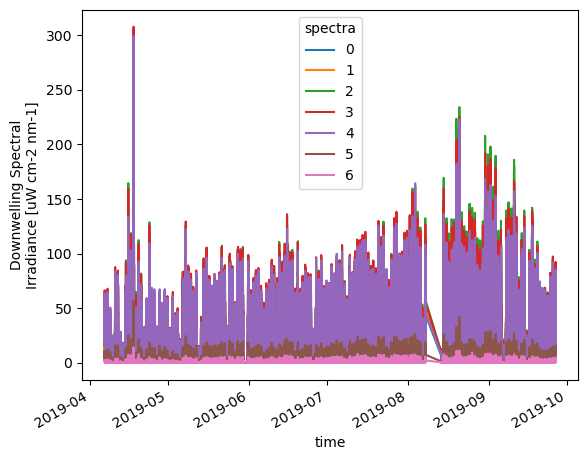

In [11]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
spkir.spkir_abj_cspp_downwelling_vector.plot.line(x="time", hue="spectra")

In [12]:
# From graph above we can see that the plotting function still connects points across gaps in data, so we will add in nan gaps
spkir_full_time = nanfill_time_gaps(spkir)
# dataset_full

Text(0.5, 1.0, 'CP01CNSM-RID26-08-SPKIRB000 recovered_host spkir_abj_dcl_instrument_recovered')

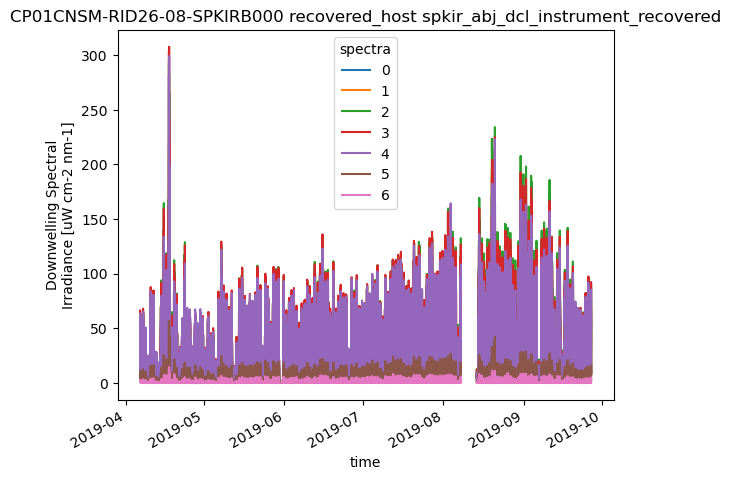

In [13]:
# Plot data with gaps in lines where data is missing
spkir_full_time.spkir_abj_cspp_downwelling_vector.plot.line(x="time", hue="spectra")
plt.title(' '.join([refdes, method, stream]))

In [20]:
# resample to weekly data by applying the median
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="7D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 25, spectra: 7)>
array([[5.60309472e-01, 7.57825601e-01, 1.19915385e+00, 1.35586219e+00,
        1.24483983e+00, 1.90202201e-01, 6.04017264e-02],
       [6.71104127e-01, 9.68263702e-01, 1.29232439e+00, 1.28403349e+00,
        1.00455252e+00, 1.41964033e-01, 5.35701718e-02],
       [7.30457757e-01, 9.47233379e-01, 1.41921449e+00, 1.56270602e+00,
        1.42984525e+00, 2.19104857e-01, 6.73434674e-02],
       [6.16534440e-01, 9.02960907e-01, 1.28976706e+00, 1.36517060e+00,
        1.21103075e+00, 1.85592410e-01, 6.05119128e-02],
       [9.77058175e-01, 1.37033040e+00, 1.85858250e+00, 1.89428765e+00,
        1.64007255e+00, 2.39583669e-01, 6.94921016e-02],
       [7.50730396e-01, 1.01371402e+00, 1.38408141e+00, 1.42682580e+00,
        1.27418665e+00, 1.91958311e-01, 5.84367362e-02],
       [2.20932357e+00, 3.24204716e+00, 4.64717962e+00, 4.93973640e+00,
        4.37635246e+00, 5.68122723e-01, 1.43362877e-01],
       [1.91292832e+00, 2.86745745e+00, 3.94485291e+00, 3.99631748e+00,
        3.43354378e+00, 4.98253295e-01, 1.33124728e-01],
       [2.44073543e+00, 3.65093815e+00, 4.92967632e+00, 4.95423536e+00,
        4.18276948e+00, 5.92854616e-01, 1.65354239e-01],
       [2.82486055e+00, 4.14347389e+00, 5.49844528e+00, 5.44084173e+00,
        4.56280353e+00, 5.79473418e-01, 1.54601887e-01],
...
       [2.44847523e+00, 3.50597367e+00, 4.76710449e+00, 4.64510290e+00,
        3.91513999e+00, 5.04417976e-01, 1.44933033e-01],
       [3.77360004e+00, 5.16941920e+00, 7.07204992e+00, 7.04802085e+00,
        5.81716072e+00, 6.85745558e-01, 1.83580901e-01],
       [2.90760639e+00, 3.67325421e+00, 4.26264078e+00, 3.92079482e+00,
        2.86975721e+00, 3.53044887e-01, 9.41738474e-02],
       [2.24010088e+00, 2.62523560e+00, 3.11232552e+00, 2.86711110e+00,
        2.22248881e+00, 3.03617687e-01, 8.03638229e-02],
       [2.45718819e+00, 2.99466438e+00, 3.38928908e+00, 3.03165186e+00,
        2.24569641e+00, 2.75739429e-01, 7.00705800e-02],
       [1.87844027e+00, 2.33885816e+00, 2.59819975e+00, 2.33792483e+00,
        1.66871582e+00, 2.00318130e-01, 4.96034626e-02],
       [1.25712800e+00, 1.50287808e+00, 1.59793006e+00, 1.37636490e+00,
        1.00454288e+00, 1.32021885e-01, 3.64270098e-02],
       [9.47554164e-01, 1.18031122e+00, 1.25332277e+00, 1.10527924e+00,
        8.15210133e-01, 1.03805210e-01, 3.15696275e-02],
       [5.32515311e-01, 6.68255665e-01, 7.73446632e-01, 6.86625959e-01,
        5.29008790e-01, 7.10610617e-02, 2.41320479e-02],
       [3.46578622e-02, 3.63749181e-02, 3.90928396e-02, 3.37226913e-02,
        2.83299188e-02, 5.40812942e-03, 5.52891652e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-13 ... 2019-09-21
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

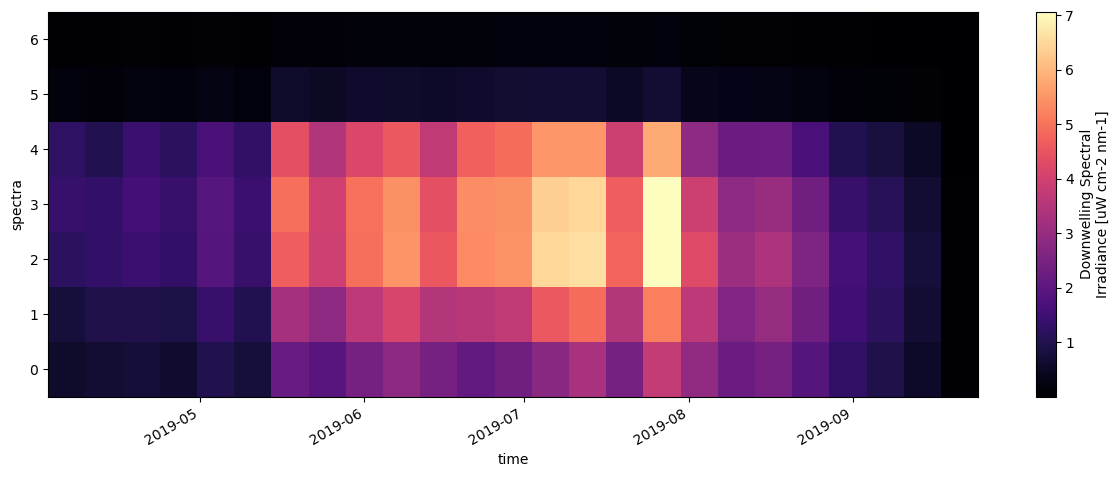

In [34]:
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5))

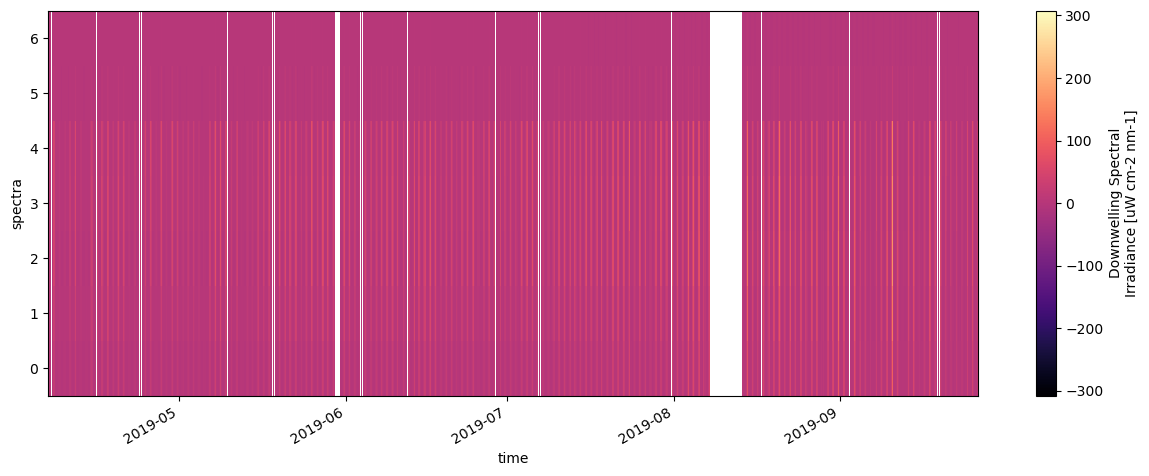

In [35]:
# Trying same plot with full resolution data
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5))

In [36]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

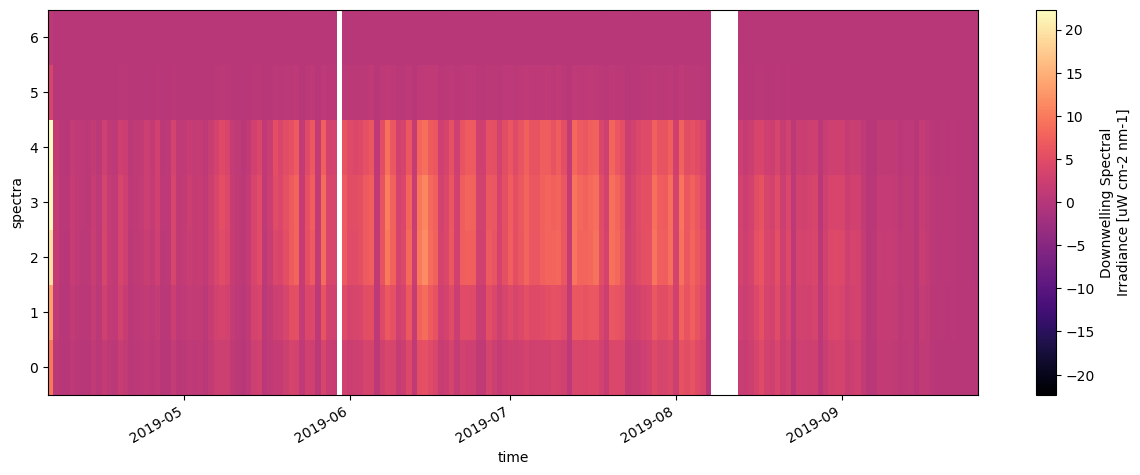

In [37]:
# pcolormesh plot
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5))

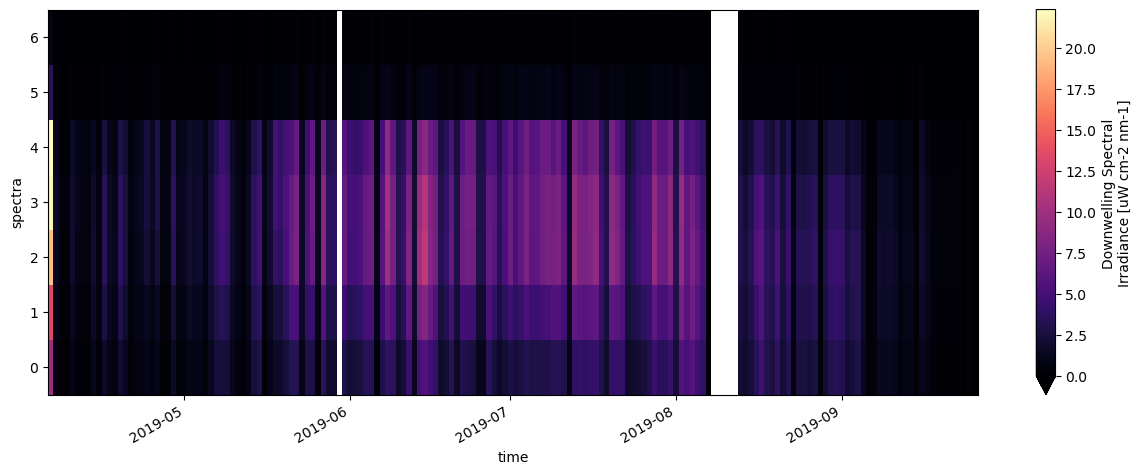

In [38]:
# Slightly better but there's still negative values
# I can set vmin=0, but this isn't a correction or anything rooted in the science behind the measurement
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), vmin=0)